In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import io
import osmnx as ox
from shapely.geometry import Polygon, LineString, Point
import os
import sys

sys.path.append(os.path.abspath(".."))
from src.helper_funcs import fetch_image
from src.helper_funcs import get_streetview_data
from src.helper_funcs import get_edges
from src.helper_funcs import get_edge_data
from src.helper_funcs import length_in_meters

In this Notenook:
1) prepare: create a list of points for API calls
2) extract: get and safe images for every point in point_list
3) enrich data: street names, length and geometry
4) load data: write png files and meta data in data folder

1. prepare: create a list of points for API calls

In [2]:
api_key = os.environ.get('api_key')

In [3]:
polygon = [[ 13.335820607449087, 52.479180814784826 ], [ 13.319144034173492, 52.481940744889087 ], [ 13.319144034173492, 52.481940744889087 ], [ 13.303192529301191, 52.491654321569996 ], [ 13.287966092832171, 52.502689873200431 ], [ 13.293041571655179, 52.511516320373843 ], [ 13.288691161235455, 52.519899803498745 ], [ 13.29014129804203, 52.526958338172669 ], [ 13.301017324091331, 52.528281687156365 ], [ 13.324219512996502, 52.530046090443768 ], [ 13.353222249127967, 52.534015738673432 ], [ 13.36337320677398, 52.538426038072501 ], [ 13.380774848452859, 52.545481595702277 ], [ 13.398176490131736, 52.54636346067177 ], [ 13.411227721390897, 52.546804386512193 ], [ 13.42355388424677, 52.541953958639048 ], [ 13.432979773489496, 52.539749041508585 ], [ 13.439505389119075, 52.537985028067389 ], [ 13.44675607315194, 52.534456788548354 ], [ 13.45183155197495, 52.526958338172669 ], [ 13.456907030797952, 52.524311520584895 ], [ 13.462707578024245, 52.523208632849773 ], [ 13.469958262057109, 52.518796804998914 ], [ 13.473583604073546, 52.513943282616047 ], [ 13.473583604073546, 52.509309874748915 ], [ 13.470683330460398, 52.505117322867868 ], [ 13.466695454242322, 52.500703678312291 ], [ 13.464882783234104, 52.497834571715572 ], [ 13.461257441217672, 52.494744555219448 ], [ 13.45799463340288, 52.492316532775945 ], [ 13.457632099201236, 52.489115752903984 ], [ 13.457088297898771, 52.486797801367324 ], [ 13.457088297898771, 52.484038175975996 ], [ 13.456000695293843, 52.4796224152363 ], [ 13.454913092688912, 52.473770849536344 ], [ 13.452375353277407, 52.472114604750061 ], [ 13.444218333740436, 52.470789564040665 ], [ 13.439505389119072, 52.469685332974741 ], [ 13.432073437985386, 52.468470646803397 ], [ 13.426816692061557, 52.46791850564356 ], [ 13.420834877734441, 52.467145496383672 ], [ 13.415396864709793, 52.466262040606331 ], [ 13.408508714878566, 52.465489002255779 ], [ 13.402889434753099, 52.465709871741218 ], [ 13.39781395593009, 52.467366357557452 ], [ 13.394732415216122, 52.468912354744376 ], [ 13.389294402191474, 52.470789564040665 ], [ 13.383131320763537, 52.471728138664126 ], [ 13.378055841940533, 52.472335440989724 ], [ 13.374067965722457, 52.472280232033704 ], [ 13.370533257256433, 52.472280232033704 ], [ 13.368720586248219, 52.472997943059788 ], [ 13.367361082992057, 52.473770849536344 ], [ 13.366545381038357, 52.475427031989611 ], [ 13.365185877782197, 52.477248760694756 ], [ 13.363645107425214, 52.478352801991761 ], [ 13.361379268664942, 52.47956721542225 ], [ 13.35893216280385, 52.480340006516634 ], [ 13.355034920136184, 52.480395205361077 ], [ 13.351500211670158, 52.479953612666179 ], [ 13.348781205157836, 52.478960012896962 ], [ 13.346062198645511, 52.478628807987505 ], [ 13.343886993435651, 52.479015213472806 ], [ 13.341258620473734, 52.479346415473572 ], [ 13.339174048814286, 52.479291215313218 ], [ 13.335820607449087, 52.479180814784826 ]]

In [4]:
polygon = Polygon(polygon)

In [5]:
G = ox.graph_from_polygon(polygon=polygon, simplify=True, network_type='drive')

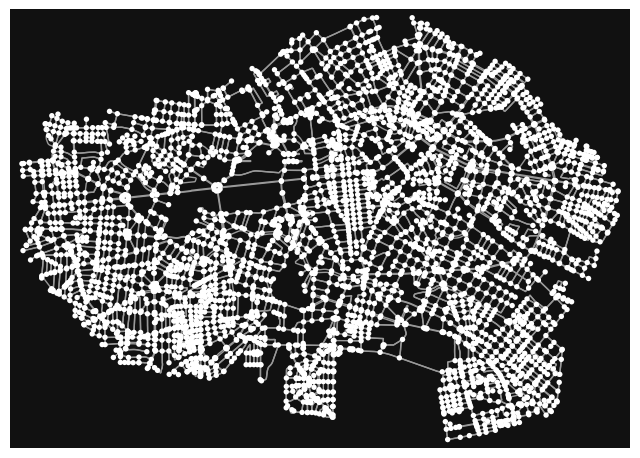

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [6]:
ox.plot_graph(G)

In [7]:
nodes, edges = ox.graph_to_gdfs(G)

In [8]:
df = edges
df.reset_index(drop=True, inplace=True)

In [9]:
distance_delta = 0.001

In [10]:
#create points in equal steps, defined by distance_delta
point_list = []

for line in df['geometry']:
    distances = np.arange(0, line.length, distance_delta)
    points = [line.interpolate(distance) for distance in distances]
    point_list.extend(points)
    
len(point_list)

23326

In [11]:
# create a unique list of points --> multiple linestrings start at same point
unique_point_list = []
seen = set()

for point in point_list:
    coord = (point.x, point.y) 
    if coord not in seen:
        seen.add(coord)
        unique_point_list.append(point)

point_list = unique_point_list

len(point_list)

16424

2. extract: get and safe images for every point in point_list

In [ ]:
request_list = [f"{point.y},{point.x}" for point in point_list]

In [13]:
# heading = True --> takes 4 steet view images for 4 different compass headings (north, west, south, east)
# https://developers.google.com/maps/documentation/streetview/request-streetview
data = [get_streetview_data(location, api_key, heading=False) for location in request_list]

In [14]:
df = pd.DataFrame([item for subset in data for item in subset])
df.head(3)

,image,date,location,pano_id
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2022-09-01,"{'lat': 52.52651944083298, 'lng': 13.447736775...",32QZ0dYnhqbei60XfjKvhQ
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2022-08-01,"{'lat': 52.52708456674286, 'lng': 13.446721969...",BJyZk0VcdJzS-YLDyxxx7w
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2022-08-01,"{'lat': 52.5375570618378, 'lng': 13.4287246473...",YAgiKXyh8Dshlm8hgv16GA


3. enrich data: street names, geometry and length

In [15]:
df['lat']  = [location.get('lat') for location in df.location]
df['lon']  = [location.get('lng') for location in df.location]

In [16]:
df['edges'] = df.apply(lambda row: get_edges(G, row['lon'], row['lat']), axis=1)

In [17]:
df['edges'] = df['edges'].apply(lambda edges: [tuple(edge) for edge in edges])

In [18]:
df[['geometry', 'edge_name']] = df['edges'].apply(lambda edges: pd.Series(get_edge_data(edges, G)))

In [19]:
df.dropna(inplace=True)

In [20]:
df['length'] = df['geometry'].apply(lambda geom: geom.length)

In [21]:
df['length'] = df['geometry'].apply(length_in_meters)

In [22]:
df['date'] = pd.to_datetime(df['date'])
df.head(3)

,image,date,location,pano_id,lat,lon,edges,geometry,edge_name,length
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2022-09-01,"{'lat': 52.52651944083298, 'lng': 13.447736775...",32QZ0dYnhqbei60XfjKvhQ,52.526519,13.447737,"[(12614600, 29784567)]","LINESTRING (13.4477389 52.526513, 13.4476831 5...",Danziger Straße,167.958422
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2022-08-01,"{'lat': 52.52708456674286, 'lng': 13.446721969...",BJyZk0VcdJzS-YLDyxxx7w,52.527085,13.446722,"[(243856097, 29270276)]","LINESTRING (13.4441546 52.5294469, 13.444285 5...",Danziger Straße,404.091440
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2022-08-01,"{'lat': 52.5375570618378, 'lng': 13.4287246473...",YAgiKXyh8Dshlm8hgv16GA,52.537557,13.428725,"[(12614644, 29266374)]","LINESTRING (13.4287152 52.5375413, 13.4287918 ...",Winsstraße,23.809807


4. load data: write png files and meta data in data folder

In [23]:
image_dir = '../data/images_xx'
os.makedirs(image_dir, exist_ok=True)

metadata = []

for idx, row in df.iterrows():
    filename = f'image_{idx}.jpg'  
    file_path = os.path.join(image_dir, filename)

    img = row['image']
    if img.mode == 'RGBA':
        img = img.convert('RGB')

    img.save(file_path, 'JPEG')
    metadata.append({
        'filename': filename,
        'date': row['date'],
        'lat': row['lat'],
        'lon':row['lon'],
        'geometry': row['geometry'],
        'street_name': row['edge_name'],
        'length':row['length']
        #'originalmode': row['image'].mode 
    })

metadata_df = pd.DataFrame(metadata)
metadata_df.to_csv('../data/images_xx/image_metadata.csv', index=False)